In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

# --- Defining and Creating the Folder ---
folder_path = 'data' 
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Directory '{folder_path}' created.")
    
# 1. Simulating imbalanced transaction data
n_transactions = 20000
data = pd.DataFrame({
    'amount': np.random.uniform(1, 5000, n_transactions),
    'hour_of_day': np.random.randint(0, 24, n_transactions),
    'is_international': np.random.choice([0, 1], n_transactions, p=[0.9, 0.1]),
    'card_present': np.random.choice([0, 1], n_transactions, p=[0.2, 0.8]),
    'is_fraud': 0
})

# 2. Injecting Fraud Logic (e.g., high amount + international + 3 AM = Likely Fraud)
fraud_mask = (data['amount'] > 3000) & (data['is_international'] == 1) & (data['hour_of_day'] < 5)
data.loc[fraud_mask, 'is_fraud'] = 1

# Saving to CSV inside the /data folder
file_name = f"{folder_path}/fraud_transactions.csv"
data.to_csv(file_name, index=False)

print(f"✅ Success! File saved at: {file_name}")

# 3. Training Model
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
model.fit(X_train, y_train)

# 4. Exporting the 'Brain'
joblib.dump(model, 'fraud_model.pkl')
print("Model trained and exported as fraud_model.pkl")

✅ Success! File saved at: data/fraud_transactions.csv
Model trained and exported as fraud_model.pkl


In [2]:
pip install fastapi uvicorn pydantic joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
!{sys.executable} -m pip install fastapi uvicorn pydantic joblib

In [4]:
import joblib
import uvicorn
import os
import nest_asyncio
from fastapi import FastAPI
from pydantic import BaseModel

# 1. Allowing FastAPI to run inside a Jupyter Notebook
nest_asyncio.apply()

app = FastAPI(title="Fraud Detection Engine")

# 2. Loading the model 
try:
    model = joblib.load('fraud_model.pkl')
    print("✅ Model loaded successfully.")
except:
    print("❌ Error: 'fraud_model.pkl' not found. Run your training code first!")

# 3. Defining Data Schema
class Transaction(BaseModel):
    amount: float
    hour_of_day: int
    is_international: int
    card_present: int

# 4. Predicting Endpoint
@app.post("/predict")
async def predict_fraud(txn: Transaction):
    features = [[txn.amount, txn.hour_of_day, txn.is_international, txn.card_present]]
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0][1]
    
    return {
        "is_fraud": bool(prediction),
        "fraud_probability": round(float(probability), 4),
        "status": "FLAGGED" if prediction else "APPROVED"
    }

# 5. Starting the server without blocking the notebook
if __name__ == "__main__":
    print("🚀 API is starting at http://127.0.0.1:8000")
    print("📝 View interactive docs at http://127.0.0.1:8000/docs")
    # Using port 8000
    config = uvicorn.Config(app, host="127.0.0.1", port=8000, log_level="info")
    server = uvicorn.Server(config)
   
    await server.serve()

INFO:     Started server process [20524]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


✅ Model loaded successfully.
🚀 API is starting at http://127.0.0.1:8000
📝 View interactive docs at http://127.0.0.1:8000/docs


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [20524]


In [5]:
import sys
# Install SHAP and Matplotlib (for plotting)
!{sys.executable} -m pip install shap matplotlib

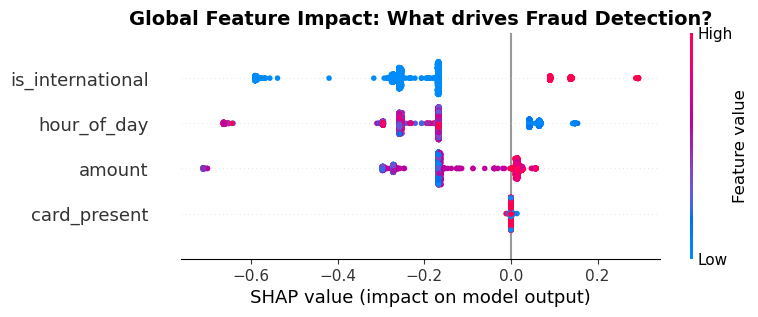

Explaining Transaction at Index 0...


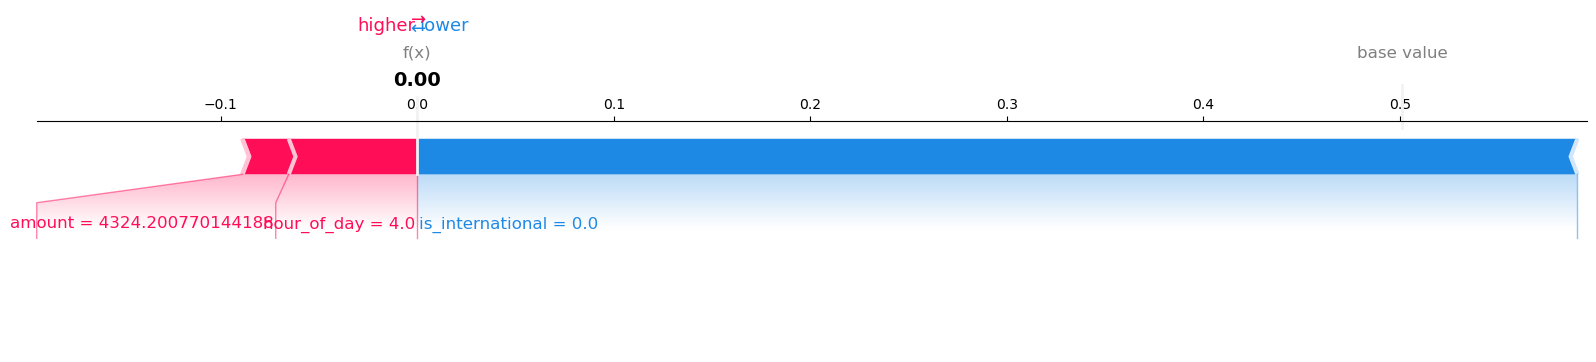

✅ Visuals saved to /visuals folder.


In [6]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Ensuring directory exists
if not os.path.exists('visuals'):
    os.makedirs('visuals')

# 2. Initializing the Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    # Using index 1 for the positive (Fraud) class
    correct_shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    # If it's a 3D array (samples, features, classes), taking class 1
    correct_shap_values = shap_values[:, :, 1]
else:
    # If already in the correct 2D format
    correct_shap_values = shap_values

# --- VISUAL 1: Global Feature Importance ---
plt.figure(figsize=(10, 6))

shap.summary_plot(correct_shap_values, X_test, show=False)
plt.title("Global Feature Impact: What drives Fraud Detection?", fontsize=14, fontweight='bold')
plt.savefig('visuals/global_fraud_importance.png', bbox_inches='tight')
plt.show()

# --- VISUAL 2: Local Explanation (Force Plot) ---
idx = 0 
print(f"Explaining Transaction at Index {idx}...")

# Using index 1 of the expected_value if it is a list
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

shap.force_plot(
    base_value, 
    correct_shap_values[idx], 
    X_test.iloc[idx], 
    matplotlib=True, 
    show=False
)
plt.savefig('visuals/fraud_explanation_sample.png', bbox_inches='tight')
plt.show()

print("✅ Visuals saved to /visuals folder.")

In [ ]:
import joblib
import uvicorn
import numpy as np
import nest_asyncio
import shap
from fastapi import FastAPI
from pydantic import BaseModel

# 1. Allowing FastAPI to run in Jupyter
nest_asyncio.apply()

app = FastAPI(title="Fraud Detection Engine with Reason Codes")

# 2. Loading the Model and Initializing SHAP globally
# This prevents the API from being slow by calculating these once at startup
model = joblib.load('fraud_model.pkl')
explainer = shap.TreeExplainer(model)
feature_names = ['amount', 'hour_of_day', 'is_international', 'card_present']

print("✅ Model and SHAP Explainer loaded.")

# 3. Defining Data Schema
class Transaction(BaseModel):
    amount: float
    hour_of_day: int
    is_international: int
    card_present: int

# 4. Predicting Endpoint with "Reason Codes"
@app.post("/predict_with_reason")
async def predict_with_reason(txn: Transaction):
    # Preparing input
    features = np.array([[txn.amount, txn.hour_of_day, txn.is_international, txn.card_present]])
    
    # Getting standard prediction
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0][1]
    
    reason = "None"
    
    # If the transaction is flagged, then we will find the "Reason Code" using SHAP
    if prediction == 1:
        # Calculating SHAP values for this one specific transaction
        sv = explainer.shap_values(features)
        
        # Determining which class output to look at (handle SHAP version differences)
        # We want the values for Class 1 (Fraud)
        if isinstance(sv, list):
            val = sv[1]
        elif len(sv.shape) == 3:
            val = sv[:, :, 1]
        else:
            val = sv
            
        # Finding the index of the feature with the highest positive impact on fraud
        impactful_feature_idx = np.argmax(val[0]) 
        reason = f"High risk detected due to: {feature_names[impactful_feature_idx]}"
    
    return {
        "is_fraud": bool(prediction),
        "fraud_probability": round(float(probability), 4),
        "status": "FLAGGED" if prediction else "APPROVED",
        "reason_code": reason
    }

# 5. Starting Server
if __name__ == "__main__":
    print("🚀 API Live: http://127.0.0.1:8000")
    print("📝 Test 'Reason Codes' at: http://127.0.0.1:8000/docs")
    config = uvicorn.Config(app, host="127.0.0.1", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

✅ Model and SHAP Explainer loaded.
🚀 API Live: http://127.0.0.1:8000
📝 Test 'Reason Codes' at: http://127.0.0.1:8000/docs


INFO:     Started server process [20524]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
